# EDA and data loading for SPECT scan dataset
##### Kevin Stull
I am working with this dataset for my final project in my machine learning class. It does not explicitly cover content seen in the last two weeks of this class, but it is relevant to topics we have covered in this course and I figured it was interesting enough to share. The task is to detect the presence of neurological pathologies in a patient using their SPECT scan. The data set is not publicly available but I am allowed to use it for demonstration purposes.

In [1]:
import os
import numpy as np
import nibabel as nib

In [2]:
os.getcwd()

'c:\\Users\\inspect\\InSpect'

In [3]:
# pointing to our file
data_path = os.getcwd() + '/datasets/ptsd/'
example_filename = os.path.join(data_path, 'sub-1928_ses-rest_spect_MNI_max.nii')

In [4]:
img = nib.load(example_filename)

In [5]:
# The image is a 3D grid of volumetric pixels (voxels)
img.shape

(79, 95, 79)

In [6]:
# each voxel has an 8 digit floating point value between 0 and 1
img.get_data_dtype()

dtype('<f8')

In [7]:
# This function is from the NiBabel library used to get the binary data needed to plot these scans
data = img.get_fdata()
type(data)

numpy.memmap

In [8]:
# This is the value of a single voxel somewhere in the middle of the brain
data[45][45][45]

0.5562044191147731

In [9]:
# Installing some libraries that I will use to visualize slices of the scan
%pip install mayavi -q
%pip install PyQt5 -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


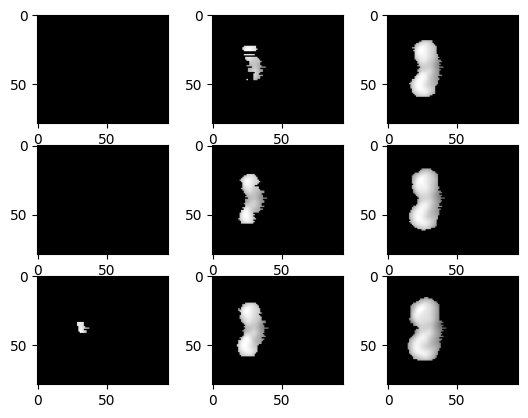

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a 3D numpy array called "data"
fig, axs = plt.subplots(nrows=3, ncols=3)
for i in range(3):
    for j in range(3):
        axs[i, j].imshow(data[:, :, i+j*3], cmap='gray')

plt.show()

In [11]:
# library used for 3d visualization of the scan
%pip install trame -q
%pip install pyvista
%pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [12]:
# I re-declare everything here because that's what allows this to render consistently
import pyvista as pv
import os
import numpy as np
import nibabel as nib

data_path = os.getcwd() + '/datasets/ptsd/'
example_filename = os.path.join(data_path, 'sub-1928_ses-rest_spect_MNI_max.nii')
img = nib.load(example_filename)
data = img.get_fdata()

grid = pv.UniformGrid()
grid.dimensions = data.shape
grid.origin = (0, 0, 0) # Define the origin point of the grid
grid.spacing = (1, 1, 1) # Define the spacing between each point in the grid
grid["data"] = data.flatten(order="F") # Flatten the 3D data array

# Create a plotter object and add the volumetric data
plotter = pv.Plotter()
plotter.add_volume(grid, cmap="bone")

# Display the plot
plotter.show()

# NOTE: Froze this so that it works with the Jupyter Notebook upload

Widget(value="<iframe src='http://localhost:56785/index.html?ui=P_0x2c382c3f970_0&reconnect=auto' style='width…

### Loading the Dataset
It has already been spatially normalized and all voxel values are between 0 and 1. So all I need to do is load it up and assign labels. The dataset is pretty small, so my expectations of this version (without transfer learning) are pretty low. There are two versions of each file, one contains the raw image of the scan data, and one is the normalized versions. I will be using the normalized versions so we can just check for which filenames contain 'max'.

In [13]:
# Here we will just index through each folder and count how many normalized scans there are
counter = 0
top_dir = 'datasets'
for folder in os.listdir(top_dir):
    for file in os.listdir(top_dir + '/' + str(folder)):
        if 'max' not in str(file) :
            counter += 1

num_datapoints = counter
print("There are", counter, 'datapoints.')


There are 1036 datapoints.


In [14]:
# Pretty Good: But what's the distribution of the dataset?
counts = [0, 0, 0]

for i, folder in enumerate(os.listdir(top_dir)):
    for file in os.listdir(top_dir + '/' + str(folder)):
        if 'max' not in str(file):
            counts[i] += 1

print("Healthy:", counts[0])
print("PTSD:", counts[1])
print("MDD:", counts[2])

Healthy: 77
PTSD: 662
MDD: 297


### Addressing the Size of the Dataset
Like I said, not a lot of data. Let's start small, we will combine the healthy and MDD data sets together and try to train a binary classifier that can (hopefully) act as a detector for PTSD. This is using the non-normalized inputs.

In [15]:
# Here is a function to load the data into training, testing, and validation sets

import os
import nibabel as nib
import numpy as np
from sklearn.model_selection import train_test_split

def load_data(top_dir, test_size=0.2, val_size=0.1):
    # Get a list of all the file paths
    file_paths = []
    labels = []
    for i, folder in enumerate(os.listdir(top_dir)):
        for file in os.listdir(top_dir + '/' + str(folder)):
            if 'max' in str(file):
                file_paths.append(os.path.join(top_dir, folder, file))
                labels.append(i)

    # Load the images into a numpy array
    data = []
    for filename in file_paths:
        img = nib.load(filename)
        data.append(img.get_fdata())
    data = np.array(data)

    # Convert labels to numpy array
    labels = np.array(labels)

    # Reassign labels assigned to 2 to 0 so that we are training on binary data 
    labels[labels==2] = 0

    # Split the data into train, validation, and test sets
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_size, stratify=labels)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, stratify=y_train)

    return X_train, X_val, X_test, y_train, y_val, y_test


In [16]:
# Loading our data
X_train, X_val, X_test, y_train, y_val, y_test = load_data('../InSpect/datasets')

In [17]:
print("Finished Loading Data!")

Finished Loading Data!


In [18]:
# Let's check our output
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

print('X_val shape:', X_val.shape)
print('y_val shape:', y_val.shape)

print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (743, 79, 95, 79)
y_train shape: (743,)
X_val shape: (83, 79, 95, 79)
y_val shape: (83,)
X_test shape: (207, 79, 95, 79)
y_test shape: (207,)


### Conclusion
The dataset is relatively small but promising results have been generated from similarly sized datasets. Although, the complexity might necessitate more data. Next time, we can define our model architecture, including some functions to permute the data to combat over fitting.

# Data processing Functions
These functions will apply some transformations to our images to help combat over fitting. The rest of the architecture will be following the implementation details of:
 https://keras.io/examples/vision/3D_image_classification/#define-a-3d-convolutional-neural-network

In [19]:
%pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [20]:
import random
import tensorflow as tf
from scipy import ndimage

@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    # had to modify this to return float instead of double
    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume.astype(np.float32)

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume

def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((X_val, y_val))

batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(X_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(X_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [21]:
import tensorflow as tf
if len(tf.config.list_physical_devices('GPU')) >0:
    print("Using GPU")

Dimension of the SPECT scan is: (79, 95, 79, 1)


Text(0.5, 1.0, 'Slightly Rotated Slice of SPECT Scan ')

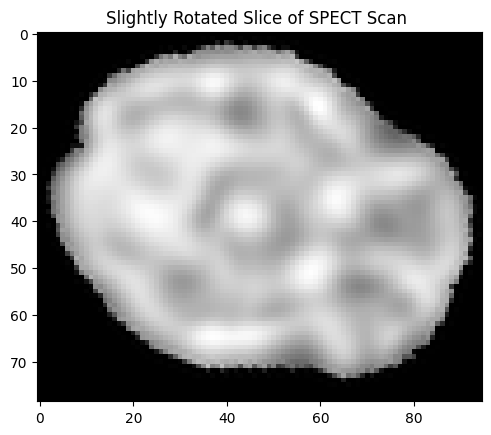

In [22]:
# Let's take a look to see what the rotation function is doing
data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the SPECT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")
plt.title("Slightly Rotated Slice of SPECT Scan ")

In [23]:
np.shape(X_train[0])

(79, 95, 79)

# Defining Our Model
We are dealing with a 3D CNN as defined by this paper https://arxiv.org/abs/2007.13224 Keras makes the model initialization pretty easy. All we need to do is modify the shape of the inputs to the dimension of the scans.

In [24]:
# Model Definition

from tensorflow import keras
from keras import layers

def get_model(width=79, height=95, depth=79):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model()
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 79, 95, 79, 1)]   0         
                                                                 
 conv3d (Conv3D)             (None, 77, 93, 77, 64)    1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 38, 46, 38, 64)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 38, 46, 38, 64)   256       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 36, 44, 36, 64)    110656    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 18, 22, 18, 64)   0     

In [25]:
# Compile model
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 5
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/5
 15/372 [>.............................] - ETA: 25:06 - loss: 0.6835 - acc: 0.5667

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

### Conclusion
I should be able to add a lot more data to the model in the future. But I am a bit concerned because this took about 8.5 hours to train as is. Also, the model seems to be converging to random guessing  (b/c the success case is about 60% of the data). Adding in transfer learning on the med3D dataset might help with improving model convergence and over fitting. As a last resort I might have to try some more complex models using attention or residual connections. I'm open to any thoughts or feedback.